In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import adjusted_rand_score
from scipy.stats import mode
import seaborn as sns

In [148]:
def outliers(df):
    """
      Remove outliers using IQR method
    """
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [149]:
def ScalData(cleaned_data):
    """
      Standardize the data
    """
    scaler = StandardScaler()
    return scaler.fit_transform(cleaned_data)

In [150]:
def elbow_method(data_scaled):
  # Elbow method to find optimal k
  wcss = []
  K_range = range(1, 11)
  for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)
  return wcss, K_range

In [151]:
def elbow_plot (wcss, K_range):
  plt.figure(figsize=(8, 5))
  plt.plot(K_range, wcss, 'bo-')
  plt.xlabel('Number of clusters (k)')
  plt.ylabel('WCSS')
  plt.title('Elbow Method For Optimal k')
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [152]:
def kmean_model(data_scaled, k=3):
  # Apply K-mean
  kmeans = KMeans(n_clusters=k, random_state=42)
  return kmeans.fit_predict(data_scaled)

In [153]:
def DBSCAN_model(data_scaled):
  # Apply DBSCAN
  dbscan = DBSCAN(eps=1.5, min_samples=5)
  return dbscan.fit_predict(data_scaled)

In [154]:
true_labels = df.loc[cleaned_data.index, "Channel"]
def match_labels(pred_labels, true_labels):
    labels = np.zeros_like(pred_labels)
    for i in np.unique(pred_labels):
        mask = (pred_labels == i)
        labels[mask] = mode(true_labels[mask])[0]
    return labels


In [155]:
def evaluate_kmeans(matched_labels, true_labels):
    acc = accuracy_score(true_labels, matched_labels)
    cm = confusion_matrix(true_labels, matched_labels)
    report = classification_report(true_labels, matched_labels)

    print(f"Accuracy: {acc:.2f}")
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", report)
    return acc, cm, report

In [156]:
def plot_confusion_matrix(cm):
  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

In [157]:
def visualize_clusters(kmean_run,data_scaled,true_labels,dbscan):
        """
        Reduce data to 2D using PCA and plot KMeans and DBSCAN cluster assignments.
        """
        # Apply PCA to reduce to 2D
        pca = PCA(n_components=2)
        pca_data = pca.fit_transform(data_scaled)

        plt.figure(figsize=(12, 5))

        # Plot KMeans Clusters
        if kmean_run is not None:
            plt.subplot(1, 2, 1)
            sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=dbscan_run, palette='Set2')
            plt.title('KMeans Clusters (PCA)')
            plt.xlabel("PCA 1")
            plt.ylabel("PCA 2")

        # Plot DBSCAN Clusters
        if dbscan_run is not None:
            plt.subplot(1, 2, 2)
            sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=dbscan_run, palette='tab10')
            plt.title('DBSCAN Clusters (PCA)')
            plt.xlabel("PCA 1")
            plt.ylabel("PCA 2")

        plt.tight_layout()
        plt.show()

In [158]:
def show_data(data):
  """
  Show the data
  """
  print(f"Data shape: {data.shape}\n")
  print('-'*55)
  print(f"Data first 10 rows: {data.head()}\n")
  print('-'*55)
  print(f"Data summary: {data.describe(include='all')})\n")
  print('-'*55)
  print(f"Data info: {data.info()}\n")
  print('-'*55)

In [159]:
def main (path):
  """
  Main function to run the app
  """
  # load data
  df = pd.read_csv(path)

  # show data
  show_data(df)

  # clean data (handle outlier)
  cleaned_data = outliers(df)
  print('-'*55)
  print(f"Cleaned data shape: {cleaned_data.shape}\n")
  print('-'*55)

  # scale data
  data_scaled = ScalData(cleaned_data)

  # find optimal k
  wcss, K_range = elbow_method(data_scaled)

  # plot elbow method
  elbow_plot(wcss, K_range)

  kmean_run = kmean_model(data_scaled)

  dbscan_run = DBSCAN_model(data_scaled)

  matched_labels = match_labels(kmean_run, true_labels)

  print('-'*55)
  print(f"KMeans cluster labels (first 10):> {kmean_run[:10]}")
  print(f"DBSCAN cluster labels (first 10):> {dbscan_run[:10]}")
  print('-'*55)

  n_clusters_dbscan = len(set(dbscan_run)) - (1 if -1 in dbscan_run else 0)
  n_noise_dbscan = list(dbscan_run).count(-1)
  print('-'*55)
  print(f"DBSCAN found {n_clusters_dbscan} clusters and {n_noise_dbscan} noise points.")
  print('-'*55)

  print('-'*55)
  # calculate acc
  acc, cm, report = evaluate_kmeans(matched_labels, true_labels)

  print('-'*55)
  #
  plot_confusion_matrix(cm)

  print('-'*55)
  #
  visualize_clusters(kmean_run,data_scaled,true_labels,dbscan_run)



In [160]:
path="/content/Wholesale customers data.csv"

Data shape: (440, 8)

-------------------------------------------------------
Data first 10 rows:    Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185

-------------------------------------------------------
Data summary:           Channel      Region          Fresh          Milk       Grocery  \
count  440.000000  440.000000     440.000000    440.000000    440.000000   
mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
min      1.000000    1.000000       3.000000     55.0

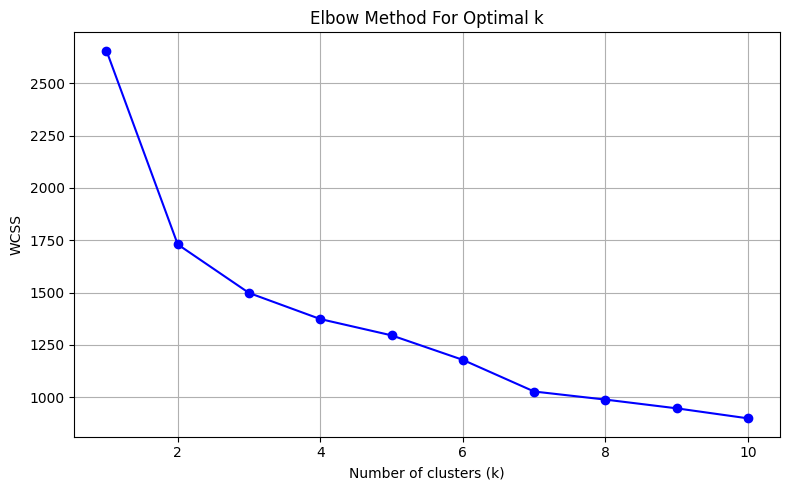

-------------------------------------------------------
KMeans cluster labels (first 10):> [0 0 2 0 0 0 1 0 0 1]
DBSCAN cluster labels (first 10):> [ 0  0  1  0  0  0  1 -1 -1  0]
-------------------------------------------------------
-------------------------------------------------------
DBSCAN found 5 clusters and 64 noise points.
-------------------------------------------------------
-------------------------------------------------------
Accuracy: 0.97
Confusion Matrix:
 [[232   5]
 [  4  91]]

Classification Report:
               precision    recall  f1-score   support

           1       0.98      0.98      0.98       237
           2       0.95      0.96      0.95        95

    accuracy                           0.97       332
   macro avg       0.97      0.97      0.97       332
weighted avg       0.97      0.97      0.97       332

-------------------------------------------------------


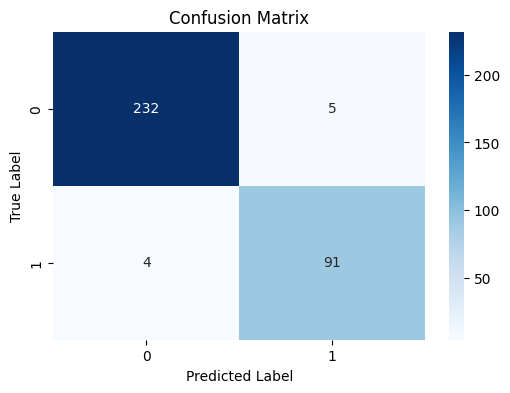

-------------------------------------------------------


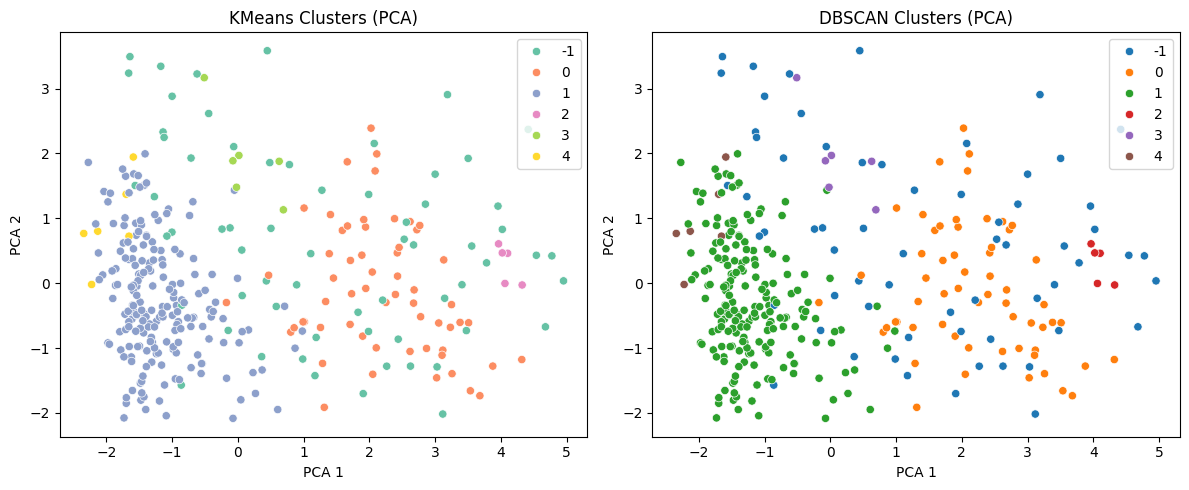

In [161]:
main(path)